In [19]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random

### Question 1)
In this question we derive the theoretical result for the waiting time for FIFO scheduling for an M/M/n queue and fro a single M/M/1 queue where we show that the average waiting time is shorter for M/M/n queue than a M/M/1 queue with the same $\rho$ and processor capacity $\mu$
(and thus an n-fold lower arrival rate).

#### Definitions and Notations:

- $\lambda$: Arrival rate into the system.
- $\mu$: Service rate of each server.
- $n$: Number of servers (here, $n=2$).
- $\rho$: System load (utilization factor), defined for an M/M/$n$ queue as:
  \begin{equation}
  \rho = \frac{\lambda}{n\mu}
  \end{equation}
- $W_q(n)$: Average waiting time in the queue for an M/M/$n$ system.
- $W(n)$: Average time in the system (waiting time plus service time) for an M/M/$n$ system.

#### for M/M/1:

We are interested in comparing the average waiting time for an M/M/1 queue and an M/M/n queue, particularly when $n = 2$, with the same load characteristic $\rho$.
The average waiting time in an M/M/1 queue can be derived using Little's Law and the formula for an M/M/1 queue:
\begin{equation}
W_q(1) = \frac{\rho}{\mu(1 - \rho)}
\end{equation}
where: $W_q$ is the average waiting time in the queue for an M/M/1 system. $\rho = \frac{\lambda}{\mu} $ is the traffic intensity of the server
\end{equation}

The average time in the system (waiting time plus service time) is:
\begin{equation}
W(1) = W_q(1) + \frac{1}{\mu} = \frac{1}{\mu - \lambda}
\end{equation}

This shows that as $\rho$ increases (i.e., as the system becomes more heavily loaded), the waiting time increases significantly due to higher congestion.

#### for M/M/n: 
Calculate the probability of zero customers in the system $P_0$ with $a = \frac{\lambda}{\mu} $


\begin{equation}
P_0 = \left( \sum_{k=0}^{n-1} \frac{a^k}{k!} + \frac{a^n}{n!(1 - \rho)} \right)^{-1}
\end{equation}

For $n=2$, this becomes:
\begin{equation}
P_0 = \left( \frac{a^0}{0!} + \frac{a^1}{1!} + \frac{a^2}{2!(1 - \rho)} \right)^{-1}
\end{equation}
Simplifying:
\begin{equation}
P_0 = \left(1 + a + \frac{a^2}{2(1 - \rho)} \right)^{-1}
\end{equation}

Calculate the average waiting time in the queue $W_q(2)$:
\begin{equation}
W_q(2) = \frac{P_w}{n\mu(1 - \rho)}
\end{equation}
For $n=2$:
\begin{equation}
W_q(2) = \frac{P_w}{2\mu(1 - \rho)}
\end{equation}

 with 
\begin{equation}
P_w = \frac{a^n}{n!(1 - \rho)} P_0
\end{equation}
For $n=2$:
\begin{equation}
P_w = \frac{a^2}{2(1 - \rho)} P_0
\end{equation}

Calculate the average time in the system $W(2)$:
\begin{equation}
W(2) = W_q(2) + \frac{1}{\mu}
\end{equation}

Due to the presence of multiple servers in the M/M/2 queue, the probability that a customer has to wait ($P_w$) is lower than in the M/M/1 queue. This results in a shorter average waiting time in the queue ($W_q(2) < W_q(1)$). Therefore, the total average time in the system is also shorter:

\begin{equation}
W(2) < W(1)
\end{equation}

#### non mathematical explanation:
The average waiting time is shorter for an M/M/2 queue compared to an M/M/1 queue with the same system load ($\rho$)because in the M/M/2 system, there are two servers sharing the workload. This reduces the probability of all servers being busy at the same time and allows more customers to be served simultaneously. Additionally, the impact of variability in arrival and service times is less pronounced when multiple servers are available, which leads to shorter queues and reduced waiting times. Essentially, the system benefits from resource pooling, where multiple servers provide flexibility and efficiency in handling customer arrivals.

In [20]:
#Theoretical

def theoretical(Lambda, mu, n):

    rho = Lambda / (n * mu)
    a = Lambda/mu
    P0 = (sum((a)**k / np.math.factorial(k) for k in range(n)) + ((a)**n / (np.math.factorial(n) * (1 - rho))))**(-1)
    Pw = ((a**n)/ (np.math.factorial(n) * (1 - rho))) * P0

    Wqn = Pw / (n * mu * (1 - rho))

    return Wqn

In [33]:
import scipy.stats as st

# Used as a guide: https://simpy.readthedocs.io/en/latest/examples/bank_renege.html
def source(env, time_total, Lambda, counter, waiting_times, mu):
    """Generates customers and puts them into the queue."""

    for i in range(time_total):
                
        c = customer(env, f'Customer{i:02d}', counter, waiting_times, mu)
        env.process(c)
        t = random.expovariate(Lambda)

        yield env.timeout(t)

def customer(env, name, counter, timer, mu):
    """Customer process for FIFO scheduling."""

    arrive = env.now
    with counter.request() as req:

        yield req
        wait = env.now - arrive
        timer.append(wait)

        time_in = random.expovariate(mu)
        yield env.timeout(time_in)

def run_simulation(num_servers, N, Lambda, mu, time_total):
    
    timer = []

    for test in range(N):

        env = simpy.Environment()

        counter = simpy.Resource(env, capacity=num_servers)
 
        env.process(source(env, time_total, Lambda, counter, timer, mu))

        env.run()

    average = np.mean(timer)
    ci = st.t.interval(0.95, len(timer) -1, loc=average, scale=st.sem(timer))
    error = (ci[1] - ci[0]) / 2
    return average, error

C:\Users\arues\AppData\Local\Temp\ipykernel_5048\3884741595.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P0 = (sum((a)**k / np.math.factorial(k) for k in range(n)) + ((a)**n / (np.math.factorial(n) * (1 - rho))))**(-1)
C:\Users\arues\AppData\Local\Temp\ipykernel_5048\3884741595.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Pw = ((a**n)/ (np.math.factorial(n) * (1 - rho))) * P0


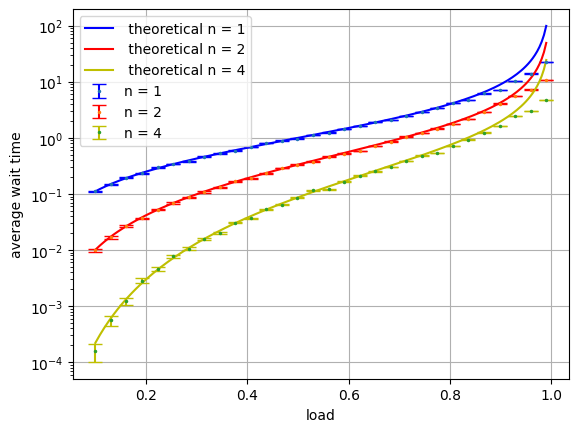

In [36]:
# Trying again for different load values


load = np.linspace(0.1, 0.99, 30)

mu = 1
time_total = 1000
#amount of repeats
N = 100
for servers in [1,2,4]:
 
    collected_times = []
    errors = []

    for value in load:

        Lambda = value * servers * mu

        result, error = run_simulation(servers, N, Lambda, mu, time_total)
        collected_times.append(result)
        errors.append(error)


    if servers == 1:
        tag = 'b'
    elif servers == 2:
        tag = 'r'
    elif servers == 4:
        tag = 'y'
    plt.errorbar(load, collected_times, yerr=errors, 
                        label = f'n = {servers}', ecolor =tag, fmt= '.',
                        capsize=5,markersize=3)
    #plt.plot(load, collected_times,'.', color =tag, label = f'n = {servers}')


load = np.linspace(0.1, 0.99, 200)

for servers in [1,2,4]:
 
    theoretical_times = []

    for value in load:

        Lambda = value * servers * mu

        result = theoretical(Lambda, mu, servers)
        theoretical_times.append(result)

    if servers == 1:
        tag = 'b'
    elif servers == 2:
        tag = 'r'
    elif servers == 4:
        tag = 'y'

    plt.plot(load, theoretical_times, color = tag, label = f' theoretical n = {servers}')

plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel('load')
plt.ylabel('average wait time')
plt.show()

#### Question 3)

we now need to compare waiting time for fifo scheduling and for smallest job first scheduling 

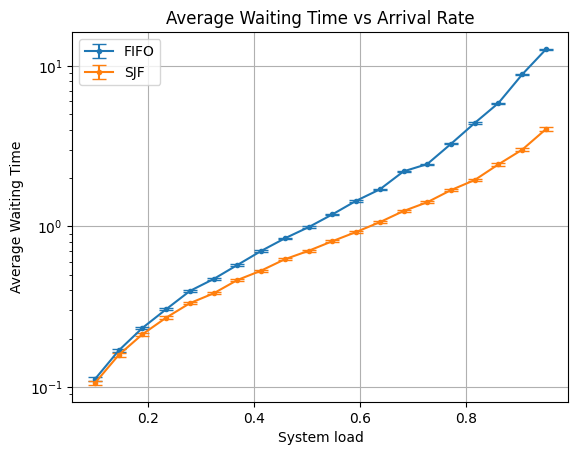

In [37]:
def source(env, time_total, Lambda, counter, waiting_times, mu, sjf=False):
    """Generates customers and puts them into the queue."""
    for i in range(time_total):
        if sjf:
            service_time = random.expovariate(mu)
            c = customer_sjf(env, f'Customer{i:02d}', counter, waiting_times, service_time)
        else:
            c = customer(env, f'Customer{i:02d}', counter, waiting_times, mu)
        env.process(c)
        t = random.expovariate(Lambda)
        yield env.timeout(t)

def customer(env, name, counter, waiting_times, mu):
    """Customer process for FIFO scheduling."""
    arrive = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        time_in = random.expovariate(mu)
        yield env.timeout(time_in)

def customer_sjf(env, name, counter, waiting_times, service_time):
    """Customer process for SJF scheduling."""
    arrive = env.now
    with counter.request(priority=service_time) as req:  # Add service time as priority
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        yield env.timeout(service_time)

def run_simulation(num_servers, N, Lambda, mu, time_total, sjf=False):
    """Runs the simulation and returns the average waiting time."""
    timer = []
    for _ in range(N):
        env = simpy.Environment()
        if sjf:
            counter = simpy.PriorityResource(env, capacity=num_servers)
        else:
            counter = simpy.Resource(env, capacity=num_servers)
        
        env.process(source(env, time_total, Lambda, counter, timer, mu, sjf))
        env.run()

    average = np.mean(timer)
    ci = st.t.interval(0.95, len(timer) -1, loc=average, scale=st.sem(timer))
    error = (ci[1] - ci[0]) / 2
    return average, error

mu = 1
Lambda_values = np.linspace(0.1, 0.95, 20)
time_total = 1000
N = 100

collected_times_fifo = []
collected_times_sjf = []

errors_fifo = []
errors_sjf = []

for Lambda in Lambda_values:
    # FIFO scheduling
    avg_wait_fifo, fifo_error = run_simulation(1, N, Lambda, mu, time_total, sjf=False)
    collected_times_fifo.append(avg_wait_fifo)
    errors_fifo.append(fifo_error)

    # SJF scheduling
    avg_wait_sjf, sjf_error = run_simulation(1, N, Lambda, mu, time_total, sjf=True)
    collected_times_sjf.append(avg_wait_sjf)
    errors_sjf.append(sjf_error)

# Plotting the results
# plt.plot(Lambda_values, collected_times_fifo, 'o-', label='FIFO')
# plt.plot(Lambda_values, collected_times_sjf, 's--', label='SJF')

plt.errorbar(Lambda_values, collected_times_fifo, yerr=errors_fifo, 
            label='FIFO', fmt= 'o-',
            capsize=5,markersize=3)
plt.errorbar(Lambda_values, collected_times_sjf, yerr=errors_sjf, 
            label='SJF', fmt= 'o-',
            capsize=5,markersize=3)
plt.xlabel('System load')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Arrival Rate')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()